# 1. Introduction

This is a lab for experimenting with trend-following ideas and techniques.  It includes the following features:

1. Data: downloads historical price data from various sources as input to the experiments.  It also simulates price data with various models to test different strategies.
1. `tr` class: a class for trading strategies upon a single asset.
1. `po` class: a class for portfolio evaluation: select assets, excecute trading strategies and evaluate performance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

import quandl

In [3]:
# Utils
def dict_list_to_DataFrame(dl): 
    dl = [{k: [i] for k, i in d.items()} for d in dl]
    out = pd.concat([DataFrame.from_dict(d) for d in dl], sort=False)
    return out

# 2. Data

The main sources of data are `Quandl`, `Cryptocompare` and `Yahoo Finance`.

## Quandl

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

In [5]:
QUANDL_PATH = 'input/Quandl/'
! ls {QUANDL_PATH}

CUR.txt     XBOM.pickle XNAS.csv    XSES.csv    XSHG.pickle
SCF.csv     XHKG.csv    XNAS.pickle XSES.pickle XTSE.csv
XASE.csv    XLON.csv    XNSE.csv    XSHE.csv    XTSE.pickle
XBOM.csv    XLON.pickle XNYS.csv    XSHG.csv    XTSX.csv


In [6]:
# Free sample tickers from Exchange Data International
QUANDL_FREE_SAMPLES_EDI = {
    # https://www.quandl.com/data/XNAS-NASDAQ-Stock-Market-Prices
    'XNAS': ['AAL', 'AAME', 'AAON', 'AAPL', 'AAXJ', 'ABAC', 'ABAX',
             'ABCO', 'ABG', 'ABM', 'ABTL', 'ACET', 'ACIW', 'ACLS', 'ACNB'],
    # https://www.quandl.com/data/XBOM-Bombay-Stock-Exchange-Prices
    'XBOM': ['500002', '500003', '500008', '500010', '500012',
             '500013', '500020', '500023', '500024', '500027',
             '500031', '500032', '500038', '500039', '500040'],
    # https://www.quandl.com/data/XTSE-Toronto-Stock-Exchange-Prices
    'XTSE': ['AAB', 'ABT', 'ABX', 'ACD', 'ACQ', 'AEM', 'AFN', 'AGT',
             'AGU', 'AIF', 'ALA', 'ALB', 'ALC', 'ALO', 'AND'],
    # https://www.quandl.com/data/XSHG-Shanghai-Stock-Exchange-Prices
    'XSHG' : ['600000', '600004', '600006', '600007', '600009',
              '600010', '600011', '600012', '600015', '600016',
              '600017', '600019', '600020', '600021', '600026'],
    # https://www.quandl.com/data/XLON-London-Stock-Exchange-Prices
    'XLON': ['AAIF', 'AAL', 'AAS', 'ABBY', 'ABC', 'ABF', 'ADIG', 
             'ADM', 'ADT', 'AEFS', 'AEO', 'AEP', 'AFN', 'AFS', 'AGK'],
    # https://www.quandl.com/data/XSES-Singapore-Exchange-Prices
    'XSES': ['1B6', '1C0', 'A04', 'A05', 'AFC', 'AGS', 'AUE', 'AVX', 
             'BBW', 'BCD', 'BCV', 'BCX',  'BCY', 'BEC', 'BESU'],
    # https://www.quandl.com/data/XNYS-New-York-Stock-Exchange-Prices
    'XNYS': ['A', 'AAT', 'AB', 'ABB', 'ABBV', 'ABC', 'ABEV', 'ABG', 
             'ABM', 'ABR', 'ABT', 'ABX', 'ACC', 'ADC', 'ADM'],
    # https://www.quandl.com/data/XHKG-Hong-Kong-Stock-Exchange-Prices
    'XHKG': ['00002', '00003', '00004', '00005', '00006',
             '00008', '00010', '00011', '00012', '00014',
             '00015', '00016', '00017', '00018', '00019'],
    # https://www.quandl.com/data/XASE-NYSE-MKT-AMEX-Prices
    'XASE': ['ABE', 'ACU', 'ACY', 'ADK', 'AE',  'AMS', 'ARNC_P',
             'BAA', 'BDL', 'BFY', 'BHB', 'BHV', 'BLE', 'BLJ', 'BTI'],
    # https://www.quandl.com/data/XNSE-National-Stock-Exchange-of-India-Prices
    'XNSE': ['ABB', 'ACC', 'ACE', 'ADSL', 'AFL', 'ALICON',
             'BAJAJ_AUTO', 'BASF', 'BASML', 'BBL', 'BEL',
             'BEPL, BHEL', 'BIL', 'BIOCON'],
    # https://www.quandl.com/data/XTSX-Toronto-Ventures-Stock-Exchange-Prices
    'XTSX': ['ABI', 'ABN', 'ADD', 'ADK', 'ADL', 'AFCC', 'AFM', 'AGD', 
             'AGO', 'AHR', 'AIIM', 'ALT', 'ALZ', 'AME', 'AMK'],
    # https://www.quandl.com/data/XSHE-Shenzhen-Stock-Exchange-Prices
    'XSHE': ['200011', '200012', '200018', '200025', '200026',
             '200055', '200056', '200413', '200418', '200488',
             '200521', '200530', '200539', '200541', '200550'],
    # https://www.quandl.com/data/XJPX-Japan-Exchange-Group-Prices/documentation/coverage
    'XJPX': ['13010', '13050', '13060', '13080', '13100', '13110', 
             '13200', '13290', '13300', '13320', '13430', '13440', 
             '13450', '13480', '13760']
}

In [7]:
def saf_quandl_get(dataset, **kwargs):
    try:
        return quandl.get(dataset, **kwargs)
    except:
        return None


def get_quandl_edi(exchanges = 'XNAS', free=True, download=False, flatten=True, verbose=False):
    """
    Downloads price series from Quandl vendor Exchange Data International
    
    Parameters
    ----------
    exchanges : List with names of the exchanges from which to download prices.
    free : If True, only free sample prices are downloaded.
    download : 
        If True, downloads the prices from quandl.  
        If False, looks for previously downloaded results in the QUANDL_PATH folder.
    verbose : If True, prints downloaded tickers.
    flatten: If True, returns a flattened dict with the results.
    
    Returns
    -------
    out : a dict or dict of dicts, of pandas DataFrame for each ticker.
    """
    
    out = dict()
    
    if download:
        for x in exchanges:
            
            prices = pd.read_csv(QUANDL_PATH + x + '.csv', names=['Ticker', 'Desc.'])
            free_sample = QUANDL_FREE_SAMPLES_EDI[x]
            which_free = [re.search('|'.join(free_sample), t) is not None and re.search('_UADJ', t) is None
                          for t in prices['Ticker']]
            if free: 
                prices = prices[which_free]
                
            if verbose:
                print('Downloading prices from', x, '...')
                
            out[x] = {t: saf_quandl_get(t) for t in prices['Ticker']}
            out[x] = {k: i for k, i in out[x].items() if i is not None}
            
            with open(QUANDL_PATH + x + '.pickle', 'wb') as f:
                pickle.dump(out[x], f, pickle.HIGHEST_PROTOCOL)
            
            if verbose:
                print(list(out[x].keys()))
    
    else:
        for x in exchanges:
            try:
                with open(QUANDL_PATH + x + '.pickle', 'rb') as f:
                    out[x] = pickle.load(f)
            except:
                pass
    
    if flatten:
        out = {k: i for x in out.keys() for k, i in out[x].items()}
    
    out = {k: i[['Open', 'High', 'Low', 'Close', 'Volume']] for k, i in out.items()}

    return out

# prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()), download=True, verbose=True)

In [8]:
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
print(list(prices_dict.keys()))

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET', 'XNAS/ACNB', 'XNAS/AAPL', 'XNAS/AAME', 'XNAS/ACLS', 'XNAS/AAL', 'XNAS/ABCO', 'XNAS/ABG', 'XNAS/ABAC', 'XNAS/ACIW', 'XBOM/500003', 'XBOM/500008', 'XBOM/500012', 'XBOM/500013', 'XBOM/500002', 'XBOM/500023', 'XBOM/500024', 'XBOM/500027', 'XBOM/500031', 'XBOM/500032', 'XBOM/500038', 'XBOM/500039', 'XBOM/500020', 'XBOM/500040', 'XBOM/500010', 'XTSE/AND', 'XTSE/AFN', 'XTSE/AGT', 'XTSE/ACQ', 'XTSE/ALA', 'XTSE/AIF', 'XTSE/ALB', 'XTSE/ALO', 'XTSE/ABT', 'XTSE/ACD', 'XTSE/AEM', 'XTSE/AGU', 'XTSE/ALC', 'XTSE/ABX', 'XTSE/AAB', 'XSHG/600020', 'XSHG/600015', 'XSHG/600021', 'XSHG/600019', 'XSHG/600009', 'XSHG/600016', 'XSHG/600007', 'XSHG/600000', 'XSHG/600006', 'XSHG/600017', 'XSHG/600011', 'XSHG/600010', 'XSHG/600026', 'XSHG/600012', 'XSHG/600004', 'XLON/ADM', 'XLON/ABC', 'XLON/AFS', 'XLON/AAIF', 'XLON/ADT', 'XLON/AEFS', 'XLON/AAS', 'XLON/AFN', 'XLON/AGK', 'XLON/AAL', 'XLON/AEP', 'XLON/ABF', 'XLON/ADIG', 'XLON/ABBY', 'XLON/AEO', 'XSES/

j: 82  -  XSES/AGS


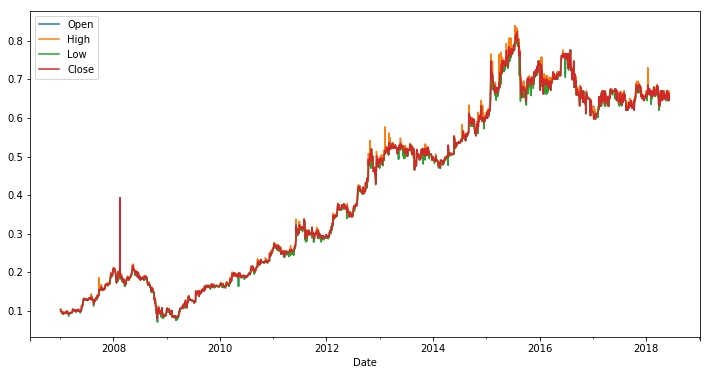

In [29]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [10]:
prices_dict[ticker_j].head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-02,614.303921,622.661797,604.851162,614.303921,2522.0
2007-01-03,614.303921,625.301549,614.303921,618.482859,12150.0
2007-01-04,618.482859,626.840735,610.124983,618.482859,4364.0
2007-01-05,618.482859,618.482859,614.303921,618.064965,2000.0
2007-01-08,618.064965,626.004948,618.064965,618.064965,1585.0


## Cryptocompare

## Yahoo Finance

## Data pre-processing

* OHLC: open and close within [low, high].

# 3. Trading Strategies

## 3.1 Definitions

In [31]:
class Trade:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, name='', strategy=None, skid=0.5):
        """
        Initializes trade class.
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
        strategy : An instance of class trading_strategy.
        name : name of the asset to trade.
        skid : skid for excecution of orders in the strategy (see http://www.seykota.com/tribe/TSP/SR/index.htm)
        """
        self.name = name
        self.prices = prices.sort_index()
        self.limit_orders = None
        self.trades = None
        self.value = None
        self.skid = skid
        self.strategy = strategy
    
    
    def plot_prices(self):
        self.prices[['Open', 'High', 'Low', 'Close']].plot()
        plt.title(self.name)


class Trading_Strategy:
    """
    Class that defines a trading strategy.
    """
    
    def __init__(self, prices, equity=100, heat=0.05, tick=100):
        self.prices = prices
        self.equity = [{'Date': None, 'Closing_Balance': equity, 'Position': 0}]
        self.heat = heat
        self.tick = tick
        self.today = None
        self.today_prices = None
        self.state = []
        self.orders = []
        self.trades = []
    
        
    
    def orders_before_trading_starts(self, prices, prev_day_position, prev_day_state, **kwargs):
        """
        Computes the orders for the day (today).
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
            Prices until today only for accessing current date.
        prev_day_position : position in the asset at the end of yesterday.
        """
        pass
    
    def excecute_orders(self, equity_to_risk=100, skid=0.5):
        """
        Excecutes orders during the day.
        """
        
        if self.equity[-1]['Date'] == self.prices.index[0]:  # First day: do nothing.
            pass
        else:
            position = self.equity[-1]['Position']  # previous day's position
            balance = self.equity[-1]['Closing_Balance']
            o = self.orders[-1]
            tp = self.today_prices
            
            if position == 0:  # Enter the market.
                
                if o['buy_stop'] is not None and o['protective_sell'] is not None and tp.High > o['buy_stop']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['buy_stop']))
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': o['amount']}
                    position += o['amount']
                    balance -= o['amount'] * buy_price
                    self.trades.append(trade)
                    
                    
                elif o['sell_stop'] is not None and o['protective_buy'] is not None and tp.Low < o['sell_stop']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['sell_stop']) - tp.Low)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': o['amount']}
                    position += o['amount']
                    balance -= o['amount'] * sell_price
                    self.trades.append(trade)
                    
            if position != 0:  # Close positions.
                
                if o['protective_buy'] is not None and tp.High > o['protective_buy']:
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Low, o['protective_buy']))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
                    
                if o['protective_sell'] is not None and tp.Low < o['protective_sell']:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.High, o['protective_sell']) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
            
            if self.today == self.prices.index.values[-1] and position != 0:  # Last day
                if position > 0:
                    sell_price = tp.Low + skid * (min(tp.Open, tp.Close, tp.High) - tp.Low)
                    amount = min(-position, 0)
                    trade = {'Date': self.today,
                             'Price': sell_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * sell_price
                    self.trades.append(trade)
                else:  # position < 0
                    buy_price = tp.High - skid * (tp.High - max(tp.Open, tp.Close, tp.Low))
                    amount = max(-position, 0)
                    trade = {'Date': self.today,
                             'Price': buy_price,
                             'Amount': amount}
                    position += amount
                    balance -= amount * buy_price
                    self.trades.append(trade)
            
            self.equity.append({'Date': self.today, 'Closing_Balance': balance, 'Position': position})
    
    def excecute(self, warmup=20):
        for i in range(1, len(self.prices)):
            self.update_state(i)
            if i >= warmup - 1:
                self.orders_before_trading_starts()
                self.excecute_orders()

    def get_state(self):
        return dict_list_to_DataFrame(self.state).set_index('Date')
    
    def get_orders(self):
        return dict_list_to_DataFrame(self.orders).set_index('Date')
    
    def get_trades(self):
        return dict_list_to_DataFrame(self.trades).set_index('Date')
    
    def get_equity(self):
        eqty = dict_list_to_DataFrame(self.equity).set_index('Date')
        eqty = pd.merge(eqty, self.prices, left_index=True, right_index=True, how='right')
        eqty['Position_Value'] = eqty['Position'] * eqty['Close']
        eqty['Equity'] = eqty['Closing_Balance'] + eqty['Position_Value']
        eqty = eqty[['Closing_Balance', 'Position', 'Position_Value', 'Equity']]
        eqty = eqty.fillna(method='bfill')
        return eqty
    
    def performance(self):
        """
        Computes performance indicators for the trading strategy.
        Maximum Draw-down
        
        Bliss
        """
        pass



class RS_Trading_Strategy(Trading_Strategy):
    """
    See http://www.seykota.com/tribe/TSP/SR/index.htm.
    """
    
    def __init__(self, prices, equity=100000, heat=0.05, tick=1, days_fast=20, days_slow=140):
        self.prices = prices
        self.equity = [{'Date': None, 'Closing_Balance': equity, 'Position': 0}]
        self.heat = heat
        self.tick = tick
        self.today = None
        self.today_prices = None
        self.state = []
        self.orders = []
        self.trades = []
        self.days_fast = days_fast
        self.days_slow = days_slow
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        self.today = self.prices.index[today_i]
        self.today_prices = self.prices.iloc[today_i]
        prices = self.prices.iloc[:today_i]  # All but today
        
        # State calculations
        Support_slow = prices[-self.days_slow:].Low.min()
        Support_fast = prices[-self.days_fast:].Low.min()
        Resistance_slow = prices[-self.days_slow:].High.max()
        Resistance_fast = prices[-self.days_fast:].High.max()
        last_price = prices.iloc[today_i - 1]
        if last_price.High >= Resistance_slow and last_price.Low > Support_slow:
            Trend = 1
        elif last_price.Low <= Support_slow and last_price.High < Resistance_slow:
            Trend = -1
        elif len(self.state) > 0:
            Trend = self.state[-1]['Trend']
        else:
            Trend = 0
        
        self.state.append(dict(Support_slow=Support_slow,
                               Support_fast=Support_fast,
                               Resistance_slow=Resistance_slow,
                               Resistance_fast=Resistance_fast,
                               Trend=Trend,
                               Date=prices.index[-1]))
    
    
    def orders_before_trading_starts(self):
        """
        Computes the orders for the day (today) according to a Support and Resistance system.
        """
        
        # Orders
        prev_day_position = self.equity[-1]['Position']
        equity_to_risk = self.equity[-1]['Closing_Balance'] * self.heat
        state = self.state[-1]
        Trend = state['Trend']
        
        orders = dict(Date = self.today,
                      buy_stop = None, sell_stop=None,
                      protective_buy=None, protective_sell=None)
        
        if prev_day_position == 0:
            if Trend == 1:
                orders['buy_stop'] = state['Resistance_fast']
                orders['protective_sell'] = state['Support_fast']
                orders['risk_per_lot'] = orders['buy_stop'] - orders['protective_sell']
                orders['amount'] = self.tick * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.tick)
            elif Trend == -1:
                orders['sell_stop'] = state['Support_fast']
                orders['protective_buy'] = state['Resistance_fast']
                orders['risk_per_lot'] = orders['protective_buy'] - orders['sell_stop'] 
                orders['amount'] = - self.tick * np.round((1e-8 + equity_to_risk / orders['risk_per_lot']) / self.tick)
        elif prev_day_position > 0:
            orders['protective_sell'] = state['Support_fast']
        elif  prev_day_position < 0:
            orders['protective_buy'] = state['Resistance_fast']
        else:
            pass
        
        self.orders.append(orders)



## 3.2 Validation

In [28]:
# Test: http://www.seykota.com/tribe/tsp/SR/SYS_SR_140-20_05_v_15/index.htm
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]
# price[['Open', 'High', 'Low', 'Close']].plot()

rs_tr = RS_Trading_Strategy(price, equity=1e6, tick=1e2, days_fast=20, days_slow=140)
rs_tr.excecute(warmup=20)

stts = rs_tr.get_state()
metrics = pd.merge(price[['Open', 'High', 'Low', 'Close']], stts, left_index=True, right_index=True)
metrics_log = pd.read_excel(io='test/Metrics_Log_1-1.xlsx', index_col=0)
assert np.all(np.equal(metrics_log.values, metrics.values))

trds = rs_tr.get_trades()
trade_log = pd.read_excel(io='test/Trade_Log.xlsx').set_index('Date').sort_index()[['Price', 'Amount']]
assert max(abs(trds.Price.values - trade_log.Price.values)) < 1e-3
assert trds.Amount.equals(trade_log.Amount.astype('float64'))

eqty = rs_tr.get_equity()
equity_log = pd.read_excel(io='test/Equity_Log.xlsx', index_col=0)
assert max(abs(eqty.Equity.values - equity_log.Equity.values)) < 1e-3

## 3.3 With one asset

j: 37  -  XTSE/ABT


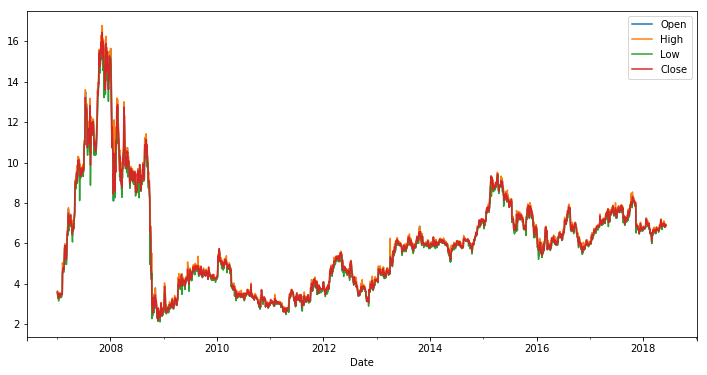

In [50]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [51]:
pr_j = prices_dict[ticker_j]
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, days_fast=30, days_slow=120)
tr_j.excecute()

In [52]:
tr_j.get_trades()

,Price,Amount
Date,,
2007-02-06,4.746315,94605.0
2007-08-16,9.620629,-94605.0
2007-10-02,12.283851,38298.0
2007-12-18,13.122044,-38298.0
2008-01-21,8.423212,-10893.0
...,...,...
2017-11-14,6.932447,-63396.0
2017-11-15,6.624446,-27192.0
2018-01-22,7.093780,27192.0


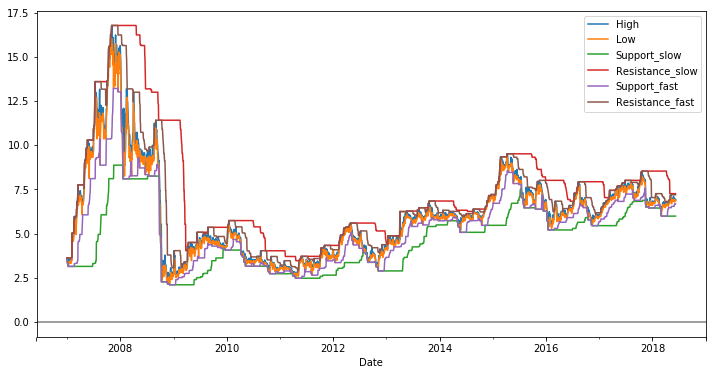

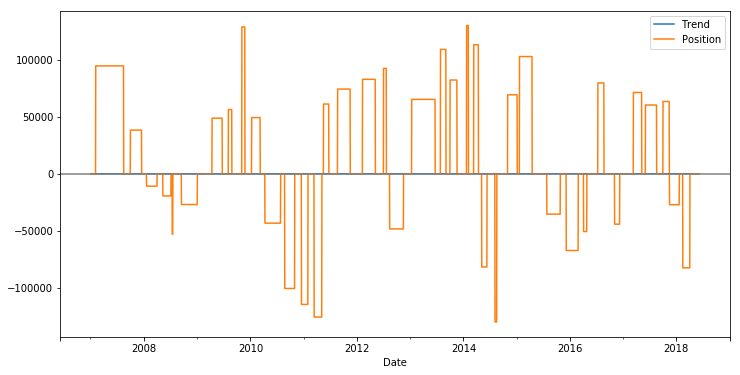

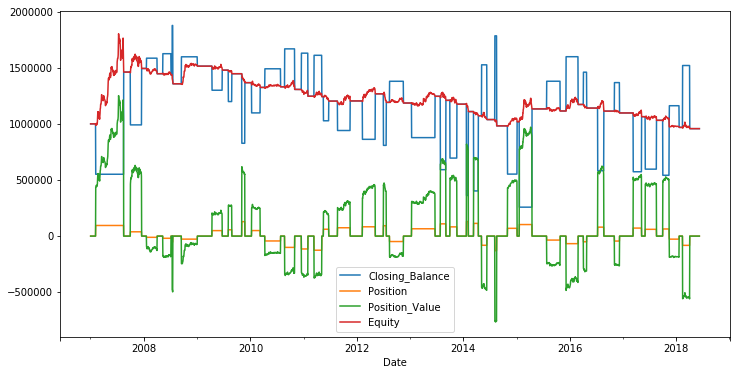

In [53]:
aux = pd.merge(pr_j, tr_j.get_state(), left_index=True, right_index=True, how='outer')
aux[['High', 'Low', 'Support_slow', 'Resistance_slow',
    'Support_fast', 'Resistance_fast']].plot()
plt.axhline(y=0, color='grey', linestyle='-')

aux = pd.merge(tr_j.get_state(), tr_j.get_equity(), left_index=True, right_index=True)
aux[['Trend', 'Position']].plot()
plt.axhline(y=0, color='grey', linestyle='-')

tr_j.get_equity().plot()

# TO DO:

* Download all series.
* Filter and curate series (eg. XNAS/AAPL).